<a href="https://colab.research.google.com/github/yunjungjoe/Classification/blob/main/Demand_FCST_Hotel_Booking_remove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proedicting a Hotel Booking Demand**

EDA to have a quick glance at the data and building a Machine Learning model to predict a hotel booking demand

## Contents

In [ ]:
# importing libraries

import pandas as pd
from pandas import plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
! pip install catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

import folium
from folium.plugins import HeatMap
import plotly.express as px

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
pd.set_option('display.max_columns', 32)

In [ ]:
# reading data
df = pd.read_csv('hotel_bookings.csv')
df.head(3)

## DATA CLEANING & PREPROCESSING

In [ ]:
# checking for null values 

null = pd.DataFrame({'# of Null Values' : df.isna().sum(), '% of Null Values' : (df.isna().sum()) / (df.shape[0]) * (100)})
null

In [ ]:
# filling null values with zero

df.fillna(0, inplace = True)

In [ ]:
# visualizing null values
msno.bar(df, color='plum')
plt.show()

In [ ]:
# adults, babies and children cant be zero at same time, so dropping the rows having all these zero at same time
filter = (df.children == 0) & (df.adults == 0) & (df.babies == 0)
df[filter]

In [ ]:
df = df[~filter]
df

## Exploratory Data Analysis (EDA)

* Q. From where the most guests are coming ?

In [ ]:
country_wise_guests = df[df['is_canceled'] == 0]['country'].value_counts().reset_index()
country_wise_guests.columns = ['country', 'No of guests']
country_wise_guests

In [ ]:
basemap = folium.Map()
guests_map = px.choropleth(country_wise_guests, locations = country_wise_guests['country'],
                           color_continuous_scale=px.colors.diverging.BrBG,
                           color = country_wise_guests['No of guests'], 
                           hover_name = country_wise_guests['country'],
                           title='Number of Guests by Home Country')
guests_map.show()

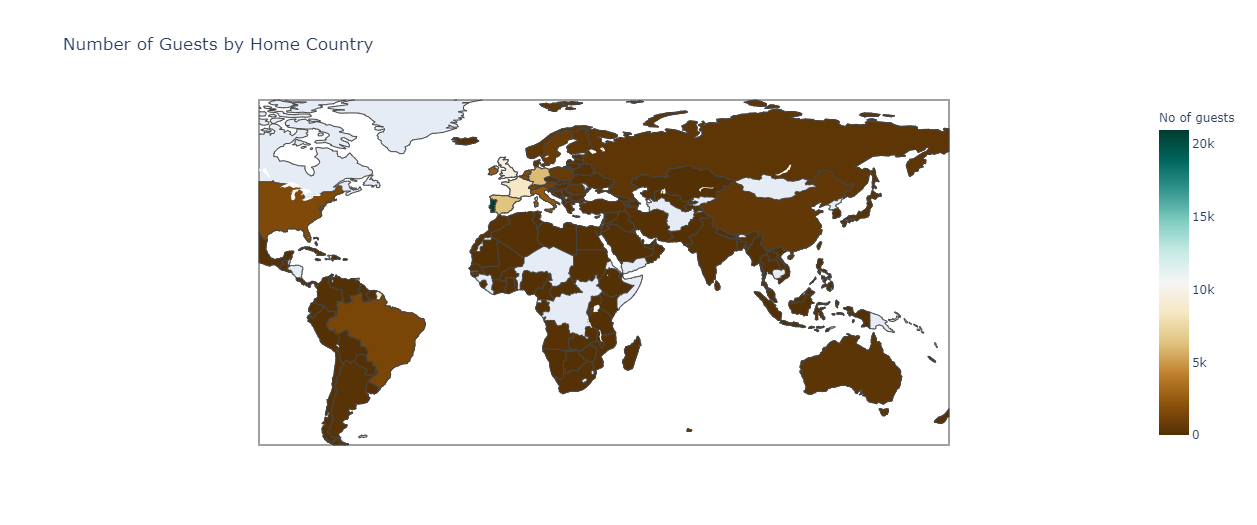

In [ ]:
# pie plot
fig = px.pie(country_wise_guests,
             values='No of guests',
             names='country',
             title="Home country of guests",
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

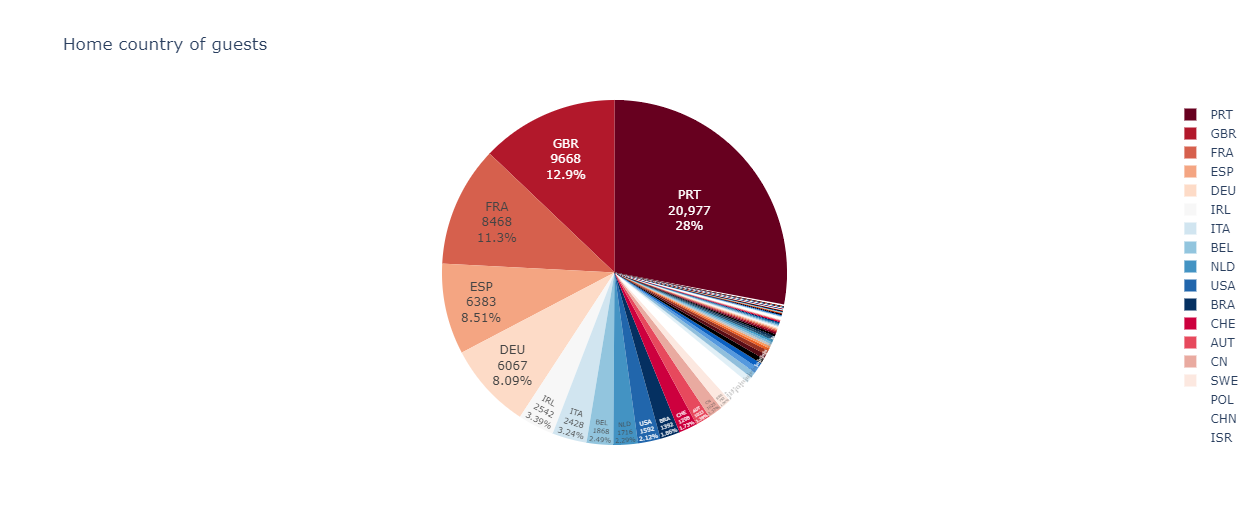

Most guests staying in these two hotels are from Portugal and Great Britain in Europe. Next in line for the highest number of guests are France, Spain, Germany, and Ireland.

* Market Segment

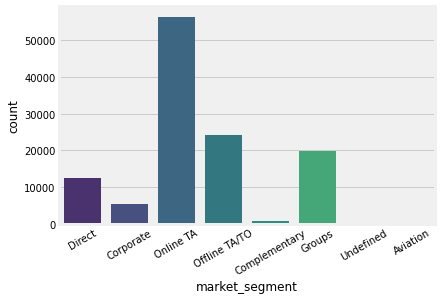

In [76]:
sns.countplot(data=df, x= 'market_segment', palette = "viridis")
plt.xticks(rotation=30,fontsize=10);

* Q. How much do guests pay for a room per night?

Both hotels have different room types and different meal arrangements.Seasonal factors are also important, So the prices varies a lot.

In [ ]:
data = df[df['is_canceled'] == 0]

px.box(data_frame = data, x = 'reserved_room_type', y = 'adr', color = 'hotel', template = 'ggplot2')

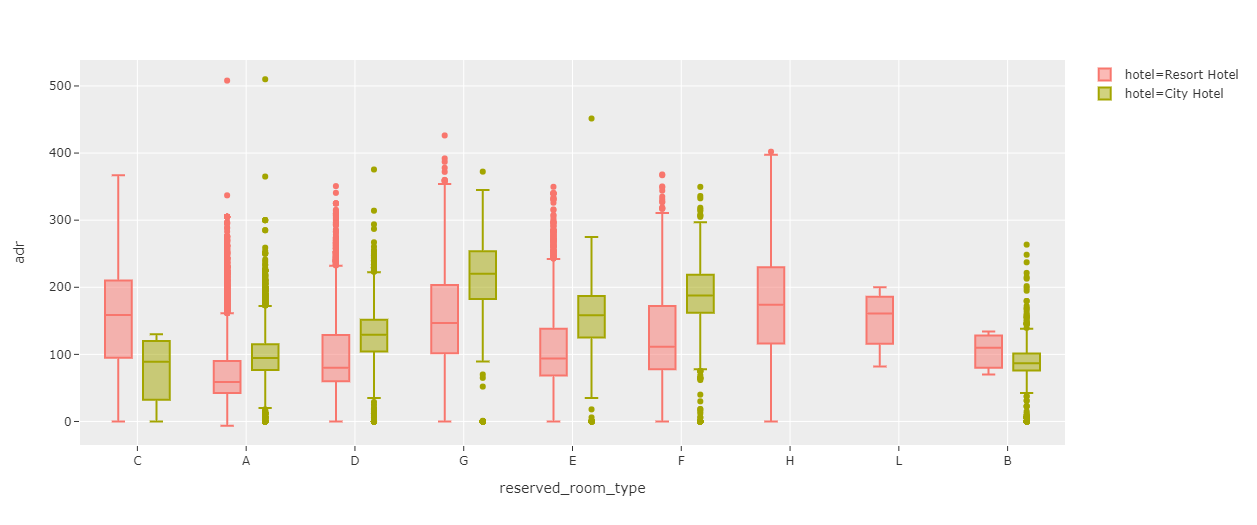

* Q. How does the price vary per night over the year?

In [ ]:
data_resort = df[(df['hotel'] == 'Resort Hotel') & (df['is_canceled'] == 0)]
data_city = df[(df['hotel'] == 'City Hotel') & (df['is_canceled'] == 0)]

In [ ]:
resort_hotel = data_resort.groupby(['arrival_date_month'])['adr'].mean().reset_index()
resort_hotel

In [ ]:
city_hotel=data_city.groupby(['arrival_date_month'])['adr'].mean().reset_index()
city_hotel

In [ ]:
final_hotel = resort_hotel.merge(city_hotel, on = 'arrival_date_month')
final_hotel.columns = ['month', 'price_for_resort', 'price_for_city_hotel']
final_hotel

In [ ]:
!pip install sort-dataframeby-monthorweek
!pip install sorted-months-weekdays

In [ ]:
import sort_dataframeby_monthorweek as sd

def sort_month(df, column_name):
    return sd.Sort_Dataframeby_Month(df, column_name)

In [ ]:
final_prices = sort_month(final_hotel, 'month')
final_prices

In [ ]:
# data
final_prices_long = pd.melt(final_prices, id_vars = ['month'], value_vars = ['price_for_resort', 'price_for_city_hotel'])

# plotly
fig = px.line(final_prices_long, x = 'month', y = 'value', color = 'variable', title = 'Room Price per Night over the Months')

# Show plot
fig.show()

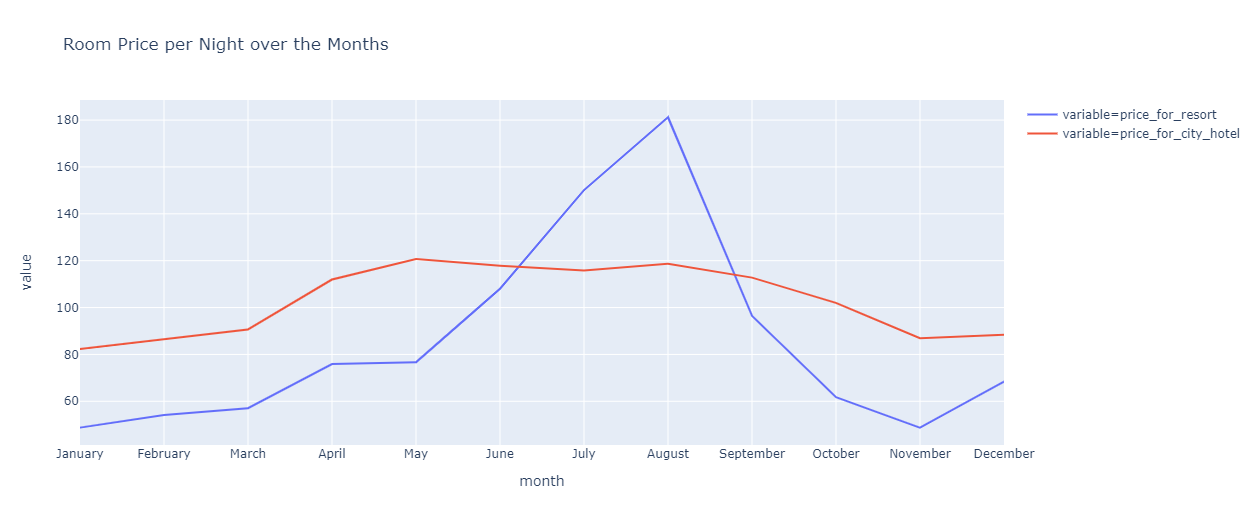

It shows that prices in the Resort Hotel are much higher during the summer and prices of city hotel varies less and is most expensive during Spring and Autumn .

 

* Q. Which are the most busy months?

In [ ]:
resort_guests = data_resort['arrival_date_month'].value_counts().reset_index()
resort_guests.columns=['month','no of guests']
resort_guests

In [ ]:
city_guests = data_city['arrival_date_month'].value_counts().reset_index()
city_guests.columns=['month','no of guests']
city_guests

In [ ]:
final_guests = resort_guests.merge(city_guests,on='month')
final_guests.columns=['month','no of guests in resort','no of guest in city hotel']
final_guests

In [ ]:
final_guests = sort_month(final_guests,'month')
final_guests

In [ ]:
# data
final_prices_long = pd.melt(final_guests, id_vars = ['month'], value_vars = ['no of guests in resort','no of guest in city hotel'])

# plotly
fig = px.line(final_prices_long, x = 'month', y = 'value', color = 'variable',
              title='Total Number of Guests per Months')

# Show plot
fig.show()

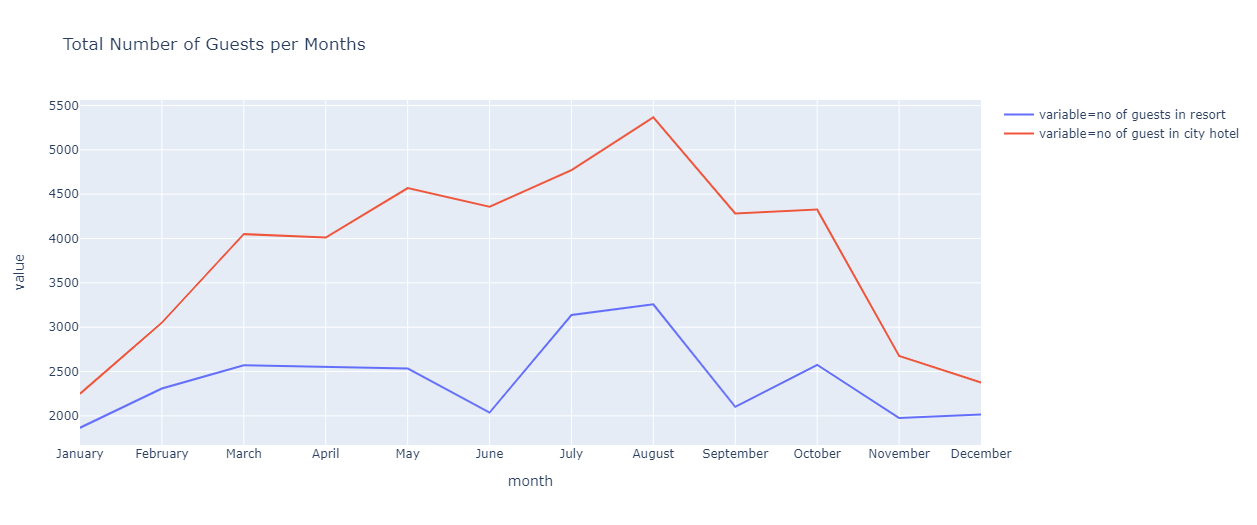

The City hotel has more guests during spring and autumn, when the prices are also highest, Guest numbers for the Resort hotel go down slighty from June to September, which is also when the prices are highest. Both hotels have the fewest guests during the winter.

* Q. How long do people stay at the hotels?

In [ ]:
filter = df['is_canceled'] == 0
data = df[filter]
data.head()

In [ ]:
data['total_nights'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']
data['total_nights']

In [ ]:
stay = data.groupby(['total_nights', 'hotel']).agg('count').reset_index()
stay = stay.iloc[:, :3]
stay = stay.rename(columns={'is_canceled':'Number of stays'})
stay

In [ ]:
px.bar(data_frame = stay, x = 'total_nights', y = 'Number of stays', color = 'hotel', barmode = 'group',
        title='How long do people stay at the hotels?')

In [ ]:
stay.describe()

# Data Pre Processing

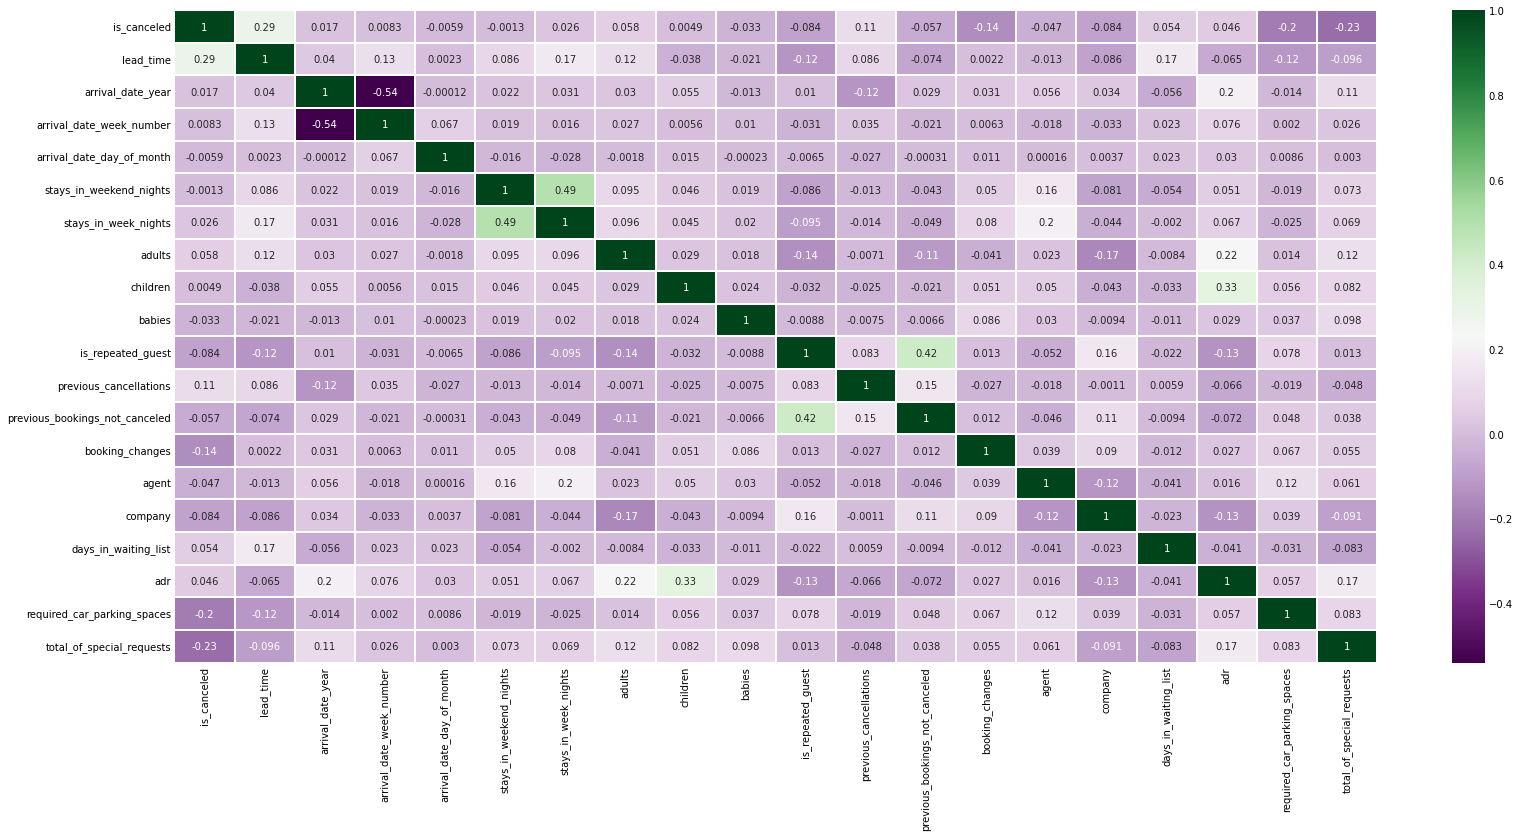

In [96]:
plt.figure(figsize = (24, 12))

corr = df.corr()
sns.heatmap(corr, annot = True, cmap='PRGn', linewidths = 1)
plt.show()

In [ ]:
correlation = df.corr()['is_canceled'].abs().sort_values(ascending = False)
correlation

In [ ]:
# dropping columns that are not useful

useless_col = ['days_in_waiting_list', 'arrival_date_year', 'arrival_date_year', 'assigned_room_type', 'booking_changes',
               'reservation_status', 'country', 'days_in_waiting_list']

df.drop(useless_col, axis = 1, inplace = True)

In [ ]:
df.head()

In [ ]:
# creating numerical and categorical dataframes

cat_cols = [col for col in df.columns if df[col].dtype == 'O']
cat_cols

In [ ]:
cat_df = df[cat_cols]
cat_df.head()

In [ ]:
cat_df['reservation_status_date'] = pd.to_datetime(cat_df['reservation_status_date'])

cat_df['year'] = cat_df['reservation_status_date'].dt.year
cat_df['month'] = cat_df['reservation_status_date'].dt.month
cat_df['day'] = cat_df['reservation_status_date'].dt.day

In [ ]:
cat_df.drop(['reservation_status_date','arrival_date_month'] , axis = 1, inplace = True)

In [ ]:
# printing unique values of each column
for col in cat_df.columns:
    print(f"{col}: \n{cat_df[col].unique()}\n")

In [ ]:
# encoding categorical variables

cat_df['hotel'] = cat_df['hotel'].map({'Resort Hotel' : 0, 'City Hotel' : 1})

cat_df['meal'] = cat_df['meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})

cat_df['market_segment'] = cat_df['market_segment'].map({'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3,
                                                           'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7})

cat_df['distribution_channel'] = cat_df['distribution_channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                                                       'GDS': 4})

cat_df['reserved_room_type'] = cat_df['reserved_room_type'].map({'C': 0, 'A': 1, 'D': 2, 'E': 3, 'G': 4, 'F': 5, 'H': 6,
                                                                   'L': 7, 'B': 8})

cat_df['deposit_type'] = cat_df['deposit_type'].map({'No Deposit': 0, 'Refundable': 1, 'Non Refund': 3})

cat_df['customer_type'] = cat_df['customer_type'].map({'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3})

cat_df['year'] = cat_df['year'].map({2015: 0, 2014: 1, 2016: 2, 2017: 3})

In [ ]:
num_df = df.drop(columns = cat_cols, axis = 1)
num_df.drop('is_canceled', axis = 1, inplace = True)
num_df

In [ ]:
num_df.var()

In [ ]:
# normalizing numerical variables

num_df['lead_time'] = np.log(num_df['lead_time'] + 1)
num_df['arrival_date_week_number'] = np.log(num_df['arrival_date_week_number'] + 1)
num_df['arrival_date_day_of_month'] = np.log(num_df['arrival_date_day_of_month'] + 1)
num_df['agent'] = np.log(num_df['agent'] + 1)
num_df['company'] = np.log(num_df['company'] + 1)
num_df['adr'] = np.log(num_df['adr'] + 1)

In [ ]:
num_df.var()

In [ ]:
num_df['adr'] = num_df['adr'].fillna(value = num_df['adr'].mean())

In [ ]:
num_df.head()

In [ ]:
X = pd.concat([cat_df, num_df], axis = 1)
y = df['is_canceled']

In [ ]:
X.shape, y.shape

In [ ]:
# splitting data into training set and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [ ]:
X_train.head()

In [ ]:
X_test.head()

In [ ]:
y_train.head(), y_test.head()

# **Model Building**

## Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
conf = confusion_matrix(y_test, y_pred_lr)
clf_report = classification_report(y_test, y_pred_lr)

print(f"Accuracy Score of Logistic Regression is : {acc_lr}\n")
print(f"Confusion Matrix : \n{conf}\n")
print(f"Classification Report : \n{clf_report}")

In [ ]:
X_train.info()

## KNN

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
conf = confusion_matrix(y_test, y_pred_knn)
clf_report = classification_report(y_test, y_pred_knn)

print(f"Accuracy Score of KNN is : {acc_knn}\n")
print(f"Confusion Matrix : \n{conf}\n")
print(f"Classification Report : \n{clf_report}")

## Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
conf = confusion_matrix(y_test, y_pred_dtc)
clf_report = classification_report(y_test, y_pred_dtc)

print(f"Accuracy Score of Decision Tree is : {acc_dtc}\n")
print(f"Confusion Matrix : \n{conf}\n")
print(f"Classification Report : \n{clf_report}")

## Random Forest Classifier

In [ ]:
rd_clf = RandomForestClassifier()
rd_clf.fit(X_train, y_train)

y_pred_rd_clf = rd_clf.predict(X_test)

acc_rd_clf = accuracy_score(y_test, y_pred_rd_clf)
conf = confusion_matrix(y_test, y_pred_rd_clf)
clf_report = classification_report(y_test, y_pred_rd_clf)

print(f"Accuracy Score of Random Forest is : {acc_rd_clf}\n")
print(f"Confusion Matrix : \n{conf}\n")
print(f"Classification Report : \n{clf_report}")

## Ada Boost Classifier

In [ ]:
ada = AdaBoostClassifier(base_estimator = dtc)
ada.fit(X_train, y_train)

y_pred_ada = ada.predict(X_test)

acc_ada = accuracy_score(y_test, y_pred_ada)
conf = confusion_matrix(y_test, y_pred_ada)
clf_report = classification_report(y_test, y_pred_ada)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_ada}\n")
print(f"Confusion Matrix : \n{conf}\n")
print(f"Classification Report : \n{clf_report}")

## Gradient Boosting Classifier

In [ ]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

acc_gb = accuracy_score(y_test, y_pred_gb)
conf = confusion_matrix(y_test, y_pred_gb)
clf_report = classification_report(y_test, y_pred_gb)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_gb}\n")
print(f"Confusion Matrix : \n{conf}\n")
print(f"Classification Report : \n{clf_report}")

## XgBoost Classifier

In [ ]:
xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
conf = confusion_matrix(y_test, y_pred_xgb)
clf_report = classification_report(y_test, y_pred_xgb)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_xgb}\n")
print(f"Confusion Matrix : \n{conf}\n")
print(f"Classification Report : \n{clf_report}")

## Cat Boost Classifier

In [ ]:
cat = CatBoostClassifier(iterations=100)
cat.fit(X_train, y_train)

y_pred_cat = cat.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)
conf = confusion_matrix(y_test, y_pred_cat)
clf_report = classification_report(y_test, y_pred_cat)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_cat}\n")
print(f"Confusion Matrix : \n{conf}\n")
print(f"Classification Report : \n{clf_report}")

## Extra Trees Classifier

In [ ]:
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

y_pred_etc = etc.predict(X_test)

acc_etc = accuracy_score(y_test, y_pred_etc)
conf = confusion_matrix(y_test, y_pred_etc)
clf_report = classification_report(y_test, y_pred_etc)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_etc}\n")
print(f"Confusion Matrix : \n{conf}\n")
print(f"Classification Report : \n{clf_report}")

## LGBM Classifier

In [ ]:
lgbm = LGBMClassifier(learning_rate = 1)
lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_test)

acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
conf = confusion_matrix(y_test, y_pred_lgbm)
clf_report = classification_report(y_test, y_pred_lgbm)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_lgbm}\n")
print(f"Confusion Matrix : \n{conf}\n")
print(f"Classification Report : \n{clf_report}")

## Voting Classifier

In [ ]:
classifiers = [('Gradient Boosting Classifier', gb), ('Cat Boost Classifier', cat), ('XGboost', xgb),  ('Decision Tree', dtc),
               ('Extra Tree', etc), ('Light Gradient', lgbm), ('Random Forest', rd_clf), ('Ada Boost', ada), ('Logistic', lr),
               ('Knn', knn)]
vc = VotingClassifier(estimators = classifiers)
vc.fit(X_train, y_train)

In [ ]:
y_pred_vc = vc.predict(X_test)

acc_vtc = accuracy_score(y_test, y_pred_vc)
conf = confusion_matrix(y_test, y_pred_vc)
clf_report = classification_report(y_test, y_pred_vc)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_vtc}\n")
print(f"Confusion Matrix : \n{conf}\n")
print(f"Classification Report : \n{clf_report}")

## ANN

In [ ]:
from tensorflow.keras.utils import to_categorical

X = pd.concat([cat_df, num_df], axis = 1)
y = to_categorical(df['is_canceled'])

In [ ]:
# splitting data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [ ]:
import keras
from keras.layers import Dense
from keras.models import Sequential

model  = Sequential()
model.add(Dense(100, activation = 'relu', input_shape = (26, )))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(2, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
                          epochs = 100)

In [ ]:
plt.figure(figsize = (12, 6))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = range(1, 101)

loss = pd.DataFrame({'train_loss' : train_loss, 'val_loss' : val_loss})

loss.head()

In [ ]:
plt.figure(figsize = (12, 6))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = range(1, 101)

loss = pd.DataFrame({'epoch' : epoch, 'train_loss' : train_loss, 'val_loss' : val_loss})

loss_long = pd.melt(loss, id_vars='epoch', value_vars=['train_loss', 'val_loss'])


px.line(data_frame = loss_long, x = 'epoch', y = 'value', color = 'variable', title = 'Training and Validation Loss')


In [ ]:
plt.figure(figsize = (12, 6))

train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy'] 
epoch = range(1, 101)

accuracy = pd.DataFrame({'epoch' : epoch, 'train_acc' : train_acc, 'val_acc' : val_acc})

accuracy_long = pd.melt(accuracy, id_vars='epoch', value_vars=['train_acc', 'val_acc'])
#accuracy_long

px.line(accuracy_long, x = "epoch", y = "value", color = 'variable', title = 'Training and Validation Accuracy')



In [ ]:
acc_ann = model.evaluate(X_test, y_test)[1]

print(f'Accuracy of model is {acc_ann}')

# **Models Comparison**

In [ ]:
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Decision Tree Classifier', 'Random Forest Classifier','Ada Boost Classifier',
             'Gradient Boosting Classifier', 'XgBoost', 'Cat Boost', 'Extra Trees Classifier', 'LGBM', 'Voting Classifier'
               , 'ANN'],
    'Score' : [acc_lr, acc_knn, acc_dtc, acc_rd_clf, acc_ada, acc_gb, acc_xgb, acc_cat, acc_etc, acc_lgbm, acc_vtc, acc_ann]
})


models.sort_values(by = 'Score', ascending = False)

In [ ]:
px.bar(data_frame = models, x = 'Model', y = 'Score', template = 'plotly_dark', title = 'Models Comparison')

In [ ]:
import plotly.express as px
px.bar(data_frame = models, x = 'Score', y = 'Model', orientation='h', color = 'Score', template = 'plotly_dark', title = 'Models Comparison')

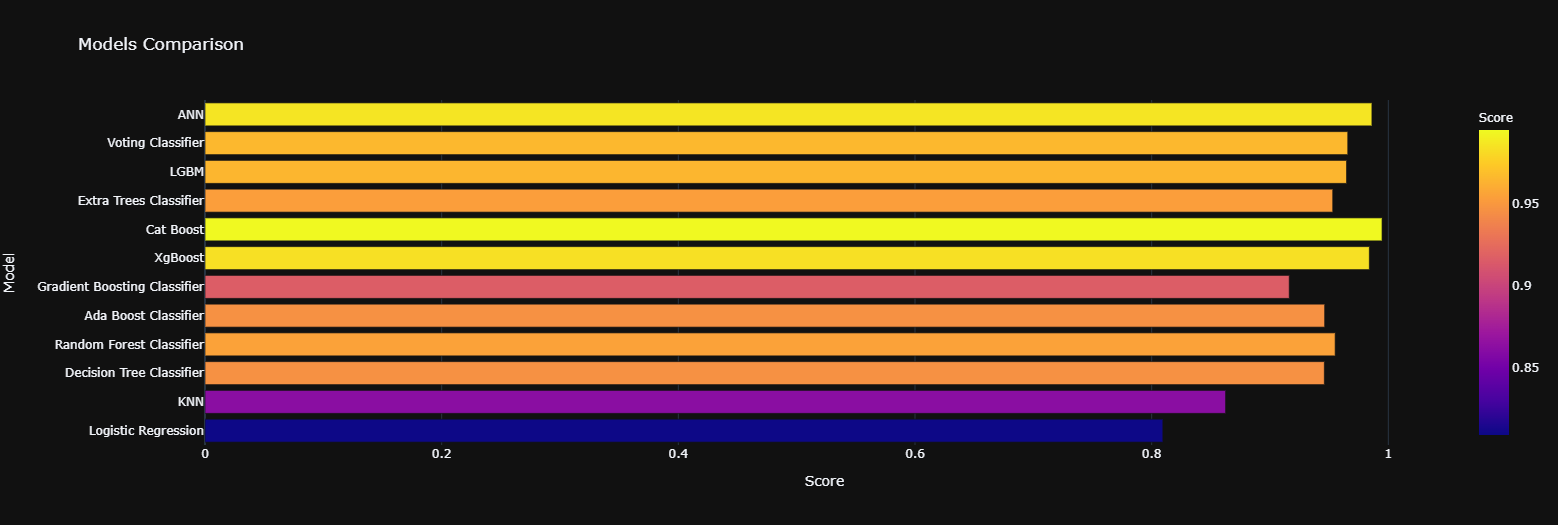